# Enoncé
## Contexte
**Mon rôle** : data scientist prestataire pour Olist

**Commanditaire** : Olist (https://olist.com/pt-br/)

**Activité de l'entreprise :** entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne

**Projet :** segmentation des clients pour leurs campagnes de communication

**Type de Mission :** classification non supervisés

## Attendus
**But de la mission :** comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles

**Détails de la mission :** fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps

données anonymisée ==> https://www.kaggle.com/olistbr/brazilian-ecommerce (comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017)

comprendre les différents types d'utilisateurs --> utiliser des méthodes non supervisées pour regrouper des clients de profils similaires --> utilisées par l’équipe Marketing pour mieux communiquer

**Problèmes :** Olist n'a pas fourni beaucoup de données --> ressources limitées --> dû fournir l’ensemble des données, alors que seuls 3 % des clients ont réalisé plusieurs commandes --> les données à disposition suffiront pour réaliser un premier clustering

**Etapes demandées :**
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :
- Réaliser une courte analyse exploratoire.
- Tester différents modèles de classification/segmentation afin de différencier les bons et moins bons clients en termes de commandes et de satisfaction sur l’ensemble des clients
- Faire une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance

/!\ Pour information, le code fourni doit respecter la convention PEP8, pour être utilisable par Olist. /!\

**Script concerné :** 
- Un notebook de l'analyse exploratoire (non cleané, pour comprendre votre démarche).
- **Un notebook (ou code commenté au choix) d’essais des différentes approches de modélisation (non cleané, pour comprendre votre démarche).**
- Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.

# Librairies, paramétrage et données
## Mise à jour des librairies

In [1]:
'''
import re
import pip
listLib = !pip list --outdated --format freeze
listLib = list(listLib)
listLib = [re.sub('(\=)+(.)+$', '', i) for i in listLib]
pip.main(['install'] + listLib + ['--upgrade'] + ['--user'])
!pip list --outdated
'''

"\nimport re\nimport pip\nlistLib = !pip list --outdated --format freeze\nlistLib = list(listLib)\nlistLib = [re.sub('(\\=)+(.)+$', '', i) for i in listLib]\npip.main(['install'] + listLib + ['--upgrade'] + ['--user'])\n!pip list --outdated\n"

## Importations des librairies

In [2]:
# Gestion des données
import pandas as pd
import numpy as np

# Système
import os
import re
import time

# Gestion des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Modélisation
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import MiniBatchKMeans, DBSCAN 
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Méthodes du coudes
from scipy.spatial.distance import cdist 

# Méthode du dendrogramme
import scipy.cluster.hierarchy as sch

## Paramétrages

In [3]:
# Format des résultats affichés
pd.set_option('display.max_columns', None) # display.max_columns : contrôle le nombre de colonnes à imprimer (int ou None pour imprimer toutes les colonnes)
pd.set_option('max_colwidth', None) # Vous pouvez augmenter la largeur en passant un int (ou mettre au max en passant None)
pd.set_option("display.max_rows", None) # Pour modifier le nombre de lignes, vous devez modifier l' option max_rows 
pd.options.display.float_format = '{:.2f}'.format # enlève le format d'affichage : nombre scientifique

# Pour afficher les graphiques dans la continuité du code, et non pas dans une fenêtre à part:
%matplotlib inline

## Importations des données

In [4]:
df = pd.read_csv('E:/Formations/6. Diplôme Data Scientist/Projet/Projet-5/olist_model.csv'
                 , sep=","
                 , decimal = '.'
                 , encoding="utf-8")

In [5]:
print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(df.shape[0],df.shape[1]).replace(',',' '))
df.sample(10)

Il y a 94 304 lignes dans le df et 5 colonnes.


,customer_unique_id,Récence,Fréquence,Montant,review_score
76445,CF5B61DFA3BCAE70246F0EE9E31AAFEB,265,1,63.87,5.00
93968,FF1F50156BB927DD992DCD54A8D2C542,265,1,238.69,3.00
92341,FA9E3C9B8708FC9FBFA29B7FE34B6693,279,1,278.66,5.00
88241,EF5B6BD043A757CD031B4F43D499A353,466,1,30.09,4.00
67608,B74751CCD05CCEA38353B81EEABB22F9,324,1,61.38,4.00
78749,D55012402364B1BBF11ACEBBA03863A3,55,1,146.45,5.00
7577,145AB5F56BB71A81592F7F7685F3E8E7,222,1,45.09,5.00
91404,F804ED90360900357B6DB9D7635D275D,470,2,630.37,5.00
83506,E25ECAD4F206325588F4B913642377EB,448,1,116.45,5.00
62303,A8D540710A95CA0C383F330D63F8070A,339,1,35.00,5.00


In [6]:
df.dtypes

customer_unique_id     object
Récence                 int64
Fréquence               int64
Montant               float64
review_score          float64
dtype: object

In [7]:
df['Montant'] = df['Montant'].astype('float16')
df['review_score'] = df['review_score'].astype('float16')

# Informations préalables

## Conclusion de la partie Nettoyage et Analyse

Les individus (clients ayant fait au moins 2 commandes) sont décris au travers de leur commande, d'un part par la segmentation **RFM** et d'autrre part par leur **satisfaction** :
- Récence : nombre de jours depuis la dernière commande
- Fréquence : nombre d'achat effectuée
- Montant : somme total des commandes
- Review_score : moyenne de leur note de satisfaction

Toutes ses informations concernent les données de la période : **début 10/2016 - début 09/2018**.
Soit, un peu moins de 2 ans.

## Nature du problème

On cherche ici à créer un modèle qui regroupera les clients suivant n catégories définis par l'algorithme suivant les différentes informations retenues.

La variable à trouver étant une variable catégorielle, ils s'agit là d'un problème de **classification**.

De plus, les catégories à trouver et affecter ne sont pas pré-définies à l'avance, leur nombre non plus. Elles doivent être trouvés par le modèle. Les données n'étant donc pas étiquetées, il s'agit d'un **apprentissage non supervisé**.

## Définitions 

### Fonction de coût/Métrique

La métrique choisit ici pour définir la performance des modèles est **le coefficient de silhouette**. Il s'agit de la différence entre :
- la distance moyenne des points des clusters entre eux &
- la distance moyenne des clusters entre eux.

A savoir que "La meilleure valeur est 1 et la pire valeur est -1. Les valeurs proches de 0 indiquent des clusters qui se chevauchent. Les valeurs négatives indiquent généralement qu'un échantillon a été affecté au mauvais groupe, car un groupe différent est plus similaire." (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)

### Algorithmes

Plusieurs choses interviennent dans le choix des algorithmes à tester : 
- la taille de l'échantillon
- la forme des données

La taille de l'échantillon > 10 000 lignes limitent le choix des algorithmes à tester. C'est pour cela, que je vais tester les 2 algorithmes qui supporte de grand jeu de données : 
- le modèle **MiniBatchKMeans** et 
- le modèle **DBSCAN**.

### Méthodes

Avant de lancer mes modèles, il faut que je détermine 
- le nombre optimal de cluster pour MiniBatchKMeans
- la valeur optimal de epsilon pour DBSCAN. 

Pour cela, je vais appliquer 2 méthodes distinctes.

In [8]:
df.describe()

,Récence,Fréquence,Montant,review_score
count,94304.00,94304.00,94304.00,94304.00
mean,242.27,1.03,NaN,NaN
std,153.00,0.21,NaN,0.00
min,0.00,1.00,9.59,1.00
25%,118.00,1.00,63.09,4.00
50%,223.00,1.00,107.88,5.00
75%,351.00,1.00,182.88,5.00
max,728.00,16.00,13664.00,5.00


# Pré-traitement
## Listes
### Combinaisons de variables à tester

In [9]:
listCombiVar = [['Récence','Fréquence','Montant'] 
                , ['Récence','Fréquence','Montant','review_score']]
listCombiVar

[['Récence', 'Fréquence', 'Montant'],
 ['Récence', 'Fréquence', 'Montant', 'review_score']]

### Transformations à tester
N'ayant que des variables quantitatives, je ne vais tester que des transformations de normalisation/standardisation.

In [10]:
listNormStand = ['MaxAbsScaler', 'MinMaxScaler', 'RobustScaler', 'StandardScaler']

## DF de mémorisation des résultats des modèles

In [11]:
df_resultats = pd.DataFrame(columns = ['Algo', 'Paramètres', 'Transformation', 'Variables'
                                       , 'nb_clusters', 'N_obs', 'Score_silhouette', 'Temps_traitement'])

## Fonctions de traitement
### Optimisation 
#### n_clusters

In [12]:
def opti_nclusters(x, listNormStand, list_clusters, algo):
    
    fig,ax = plt.subplots(1,len(listNormStand), sharex = True, figsize = (20,5))
    
    for trans in listNormStand:
        X = globals()[trans]().fit_transform(x)
        score = []

        for k in list_clusters: 
            model = globals()[algo](k)
            model.fit(X)
            score.append(model.inertia_)
 
        ax[listNormStand.index(trans)].plot(list_clusters, score, 'bx-') 
        ax[listNormStand.index(trans)].set_xlabel('K') 
        ax[listNormStand.index(trans)].set_xticks(list_clusters)
        ax[listNormStand.index(trans)].set_ylabel('Inertie') 
        ax[listNormStand.index(trans)].set_title(trans) # the elbow method using inertia
    fig.suptitle('La méthode du Coude pour '+algo+' avec : '+', '.join(x.columns.tolist()))

#### epsilon

In [13]:
def opti_epsilon(x, listNormStand):
    
    fig,ax = plt.subplots(1,len(listNormStand), sharex = True, figsize = (20,5))
    
    for trans in listNormStand:
        X = globals()[trans]().fit_transform(x)
        neigh = NearestNeighbors(n_neighbors = 2)
        nbrs = neigh.fit(X)
        distances, indices = nbrs.kneighbors(X)
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        ax[listNormStand.index(trans)].plot(distances)
        ax[listNormStand.index(trans)].set_title(trans)
        ax[listNormStand.index(trans)].set_ylim(0,np.quantile(distances,0.99))
        ax[listNormStand.index(trans)].axvline(x.shape[0]*0.9, color = 'r', linestyle = '-.')
    fig.suptitle('Avec : '+', '.join(x.columns.to_list()))

### Lancement des algorithmes

In [14]:
def algo_clustering(x, params_init, param_test, df_func, variables, transf, algo):
    
    print('---------------')
    print('Clustering',algo)
    print('---------------')
    
    param_name = list(param_test.keys())[0]
    list_test = list(param_test.values())[0]
    
    for combi in variables: # pour chaque combinaison de variables            

        df_x = x.loc[:, combi].copy()
        for t in transf: # pour chaque transformation

            preprocessor = globals()[t]()
            
            fig,ax = plt.subplots(1, len(list_test)
                                  , figsize = (10,5), subplot_kw = dict(projection = '3d'))

            for value in list_test: # pour chaque nombre de clusters
                
                params_init[param_name] = value
                model = make_pipeline(preprocessor, globals()[algo](**params_init))
                t0 = time.time()
                model.fit_predict(df_x)
                trait_time = time.time() - t0
                df_x['labels'] = model.steps[-1][1].labels_

                # n_obs
                unique, counts = np.unique(df_x['labels'], return_counts = True)
                if len(unique) == 1:
                    score_sil = -1
                else:
                    score_sil = silhouette_score(df_x.loc[:, combi], df_x['labels'])
                    
                dict_p = dict(list(model.steps[-1][1].__dict__.items())[0:2])
                df = pd.DataFrame(np.array([[algo, dict_p, t, combi
                                             , len(unique), counts.tolist()
                                             , score_sil, trait_time]]
                                           , dtype = object)
                                  , columns = ['Algo', 'Paramètres', 'Transformation', 'Variables'
                                               , 'nb_clusters', 'N_obs', 'Score_silhouette', 'Temps_traitement'])
                df_func = pd.concat([df_func, df], join = 'outer', ignore_index = True)

                df_temp = pd.DataFrame(preprocessor.fit_transform(df_x.loc[:, combi]))

                # Affichage des points des 3 axes
                a = df_temp.iloc[:,1].values
                b = df_temp.iloc[:,0].values
                c = df_temp.iloc[:,2].values
                ax[list_test.index(value)].scatter(a, b, c, c = df_x['labels'])

                # Affichage des noms des axes
                ax[list_test.index(value)].set_xlabel(combi[1])
                ax[list_test.index(value)].set_ylabel(combi[0])
                ax[list_test.index(value)].set_zlabel(combi[2])

                # Autres paramétrages
                plt.tight_layout()

                # Autres paramétrages
                ax[list_test.index(value)].set_title('Transformation '+t+' avec '+str(len(unique))+' clusters')

            fig.suptitle(', '.join(combi))
            plt.show();
    return df_func

# Optimisation 
## n_clusters

Cela consiste à lancer le modèle pour chaque valeur de k (de 1 à 10 ici) et de définir la valeur itérative de k comme paramètre n_clusters (nombre de cluster). Une fois le modèle lancé, on retient, pour chaque itération, le score de la métrique (inertie) du modèle. Enfin, une fois toutes les itérations exécutées, on affiche l'ensemble des scores sur un graphique.

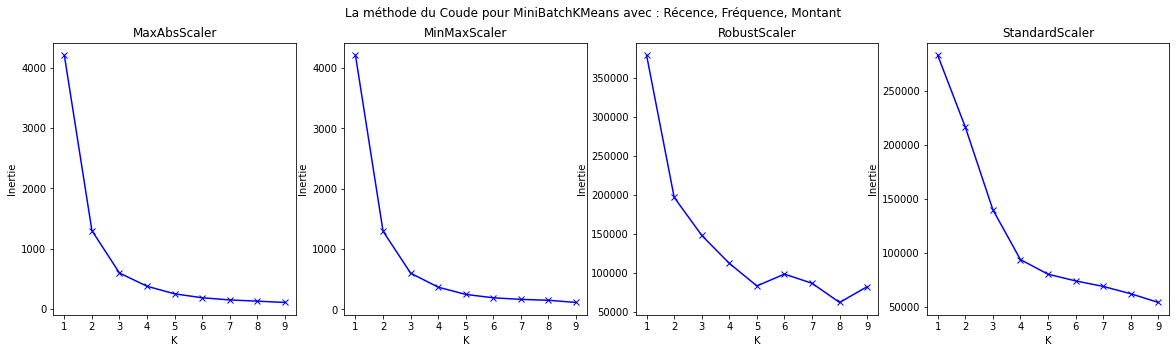

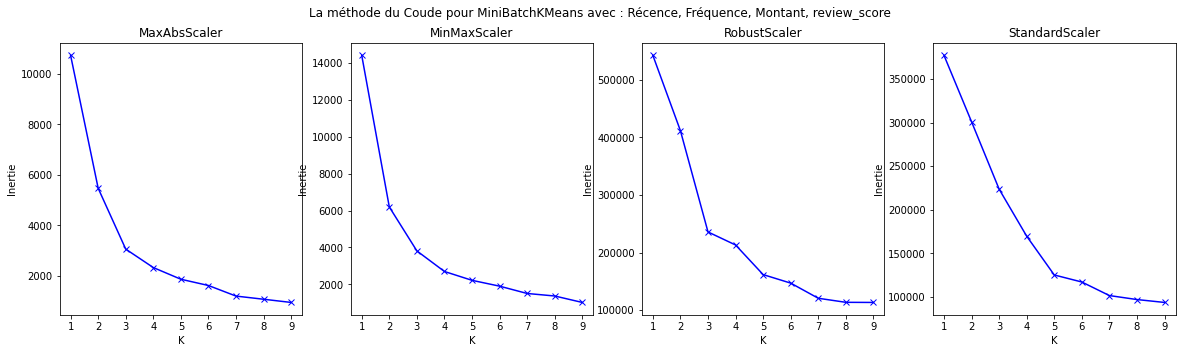

In [15]:
clusters = [*range(1,10)]

for i in [*range(0,len(listCombiVar))]:
    opti_nclusters(df.loc[:,listCombiVar[i]], listNormStand, clusters, 'MiniBatchKMeans')

Pour déterminer le nombre optimal de clusters, il faut sélectionner la valeur de k après lequel l'inertie commence à diminuer de façon linéaire (= *le coude*). Ainsi, pour les données données, on peut tester 2 nombres de clusters : **4 et 5**.

In [16]:
n_clusters = [3,4,5] # RFM + review_score

## epsilon

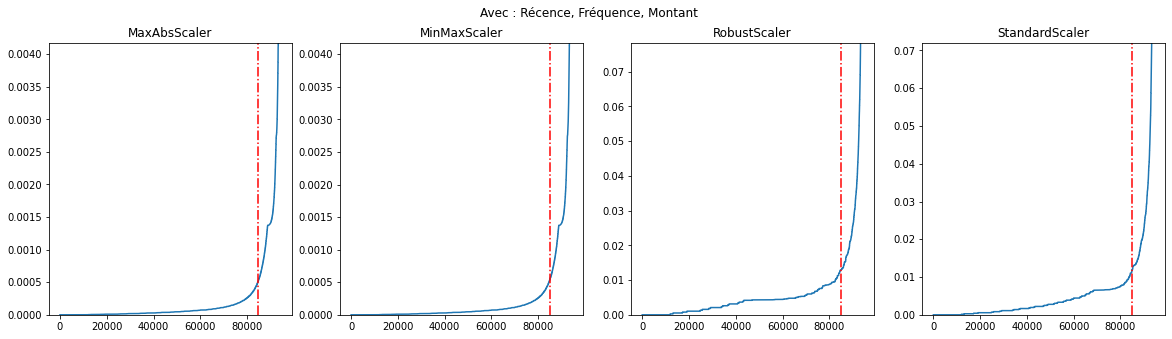

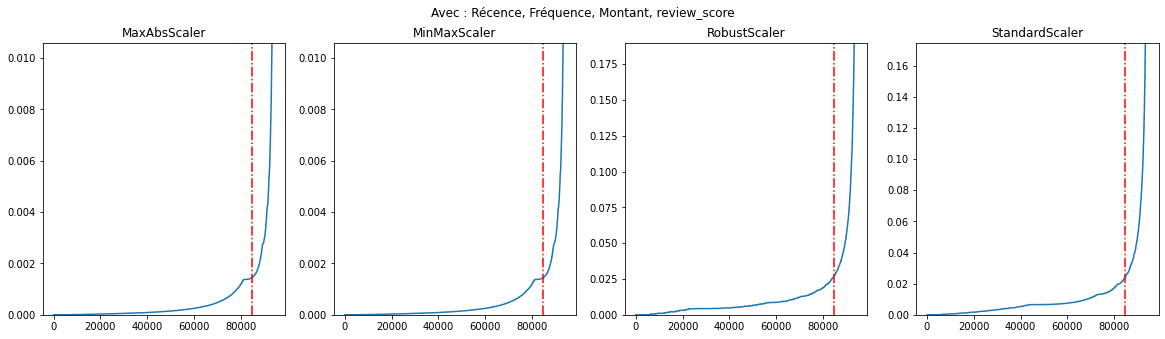

In [17]:
for var in listCombiVar:
     opti_epsilon(df.loc[:,var], listNormStand)

In [18]:
n_epsilon = [0.0005,0.002,0.02] # RFM + review_score

# Algorithmes
## MiniBatchKMeans

---------------
Clustering MiniBatchKMeans
---------------


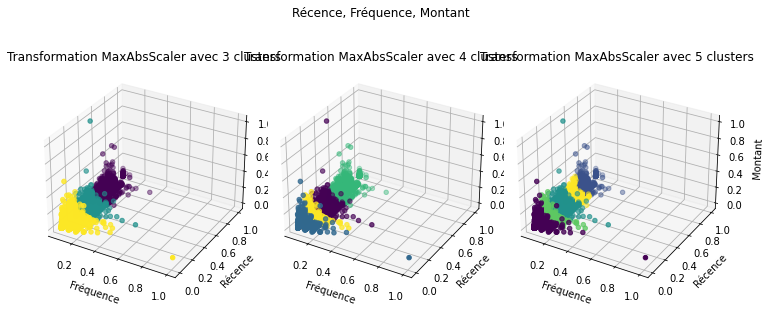

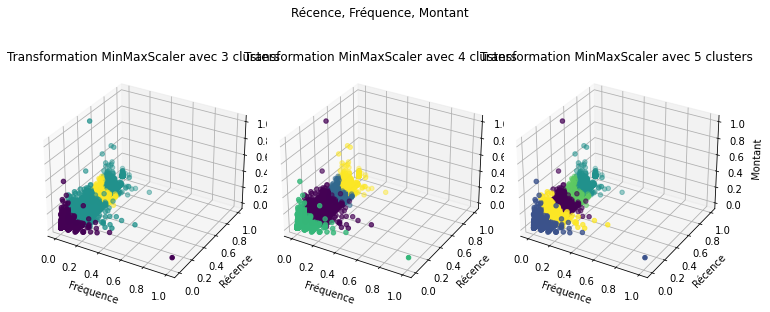

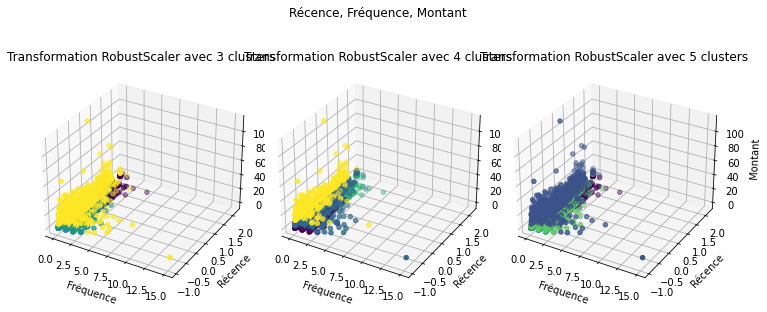

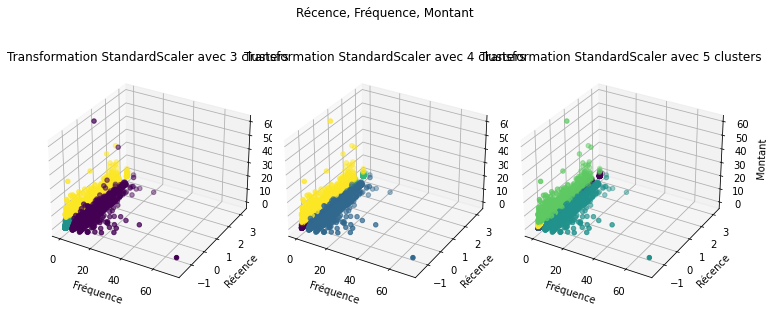

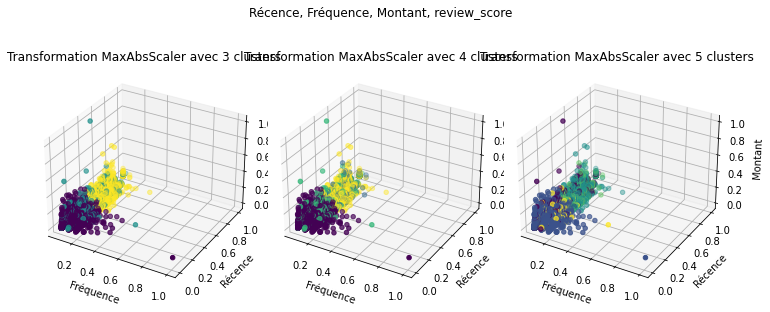

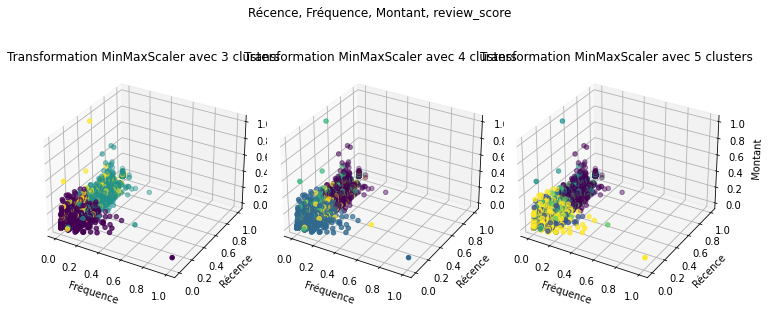

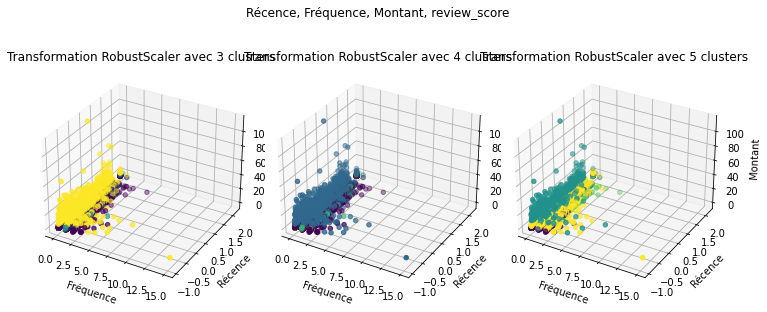

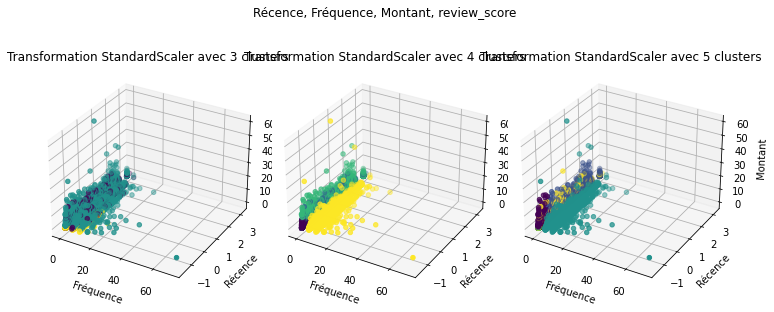

In [19]:
dict_params = {}
dict_test = {'n_clusters':n_clusters}
df_resultats = algo_clustering(df, dict_params, dict_test, df_resultats, listCombiVar, listNormStand, 'MiniBatchKMeans')

In [20]:
df_resultats[df_resultats['Algo'] == 'MiniBatchKMeans'].sort_values('Score_silhouette', ascending = False)

,Algo,Paramètres,Transformation,Variables,nb_clusters,N_obs,Score_silhouette,Temps_traitement
7,MiniBatchKMeans,"{'n_clusters': 4, 'init': 'k-means++'}",RobustScaler,"[Récence, Fréquence, Montant]",4,"[46612, 6219, 40642, 831]",0.43,0.24
6,MiniBatchKMeans,"{'n_clusters': 3, 'init': 'k-means++'}",RobustScaler,"[Récence, Fréquence, Montant]",3,"[40800, 49383, 4121]",0.41,0.23
11,MiniBatchKMeans,"{'n_clusters': 5, 'init': 'k-means++'}",StandardScaler,"[Récence, Fréquence, Montant]",5,"[21724, 57691, 2857, 2520, 9512]",0.38,0.20
8,MiniBatchKMeans,"{'n_clusters': 5, 'init': 'k-means++'}",RobustScaler,"[Récence, Fréquence, Montant]",5,"[21471, 3131, 33098, 17954, 18650]",0.33,0.05
10,MiniBatchKMeans,"{'n_clusters': 4, 'init': 'k-means++'}",StandardScaler,"[Récence, Fréquence, Montant]",4,"[67203, 2869, 21724, 2508]",0.32,0.09
9,MiniBatchKMeans,"{'n_clusters': 3, 'init': 'k-means++'}",StandardScaler,"[Récence, Fréquence, Montant]",3,"[2880, 67626, 23798]",0.31,0.13
0,MiniBatchKMeans,"{'n_clusters': 3, 'init': 'k-means++'}",MaxAbsScaler,"[Récence, Fréquence, Montant]",3,"[24388, 36660, 33256]",0.29,0.31
1,MiniBatchKMeans,"{'n_clusters': 4, 'init': 'k-means++'}",MaxAbsScaler,"[Récence, Fréquence, Montant]",4,"[36660, 17111, 24388, 16145]",0.22,0.04
20,MiniBatchKMeans,"{'n_clusters': 5, 'init': 'k-means++'}",RobustScaler,"[Récence, Fréquence, Montant, review_score]",5,"[37873, 19596, 1058, 28863, 6914]",0.20,0.11
5,MiniBatchKMeans,"{'n_clusters': 5, 'init': 'k-means++'}",MinMaxScaler,"[Récence, Fréquence, Montant]",5,"[24828, 17111, 10896, 13492, 27977]",0.19,0.04


## DBSCAN

---------------
Clustering DBSCAN
---------------


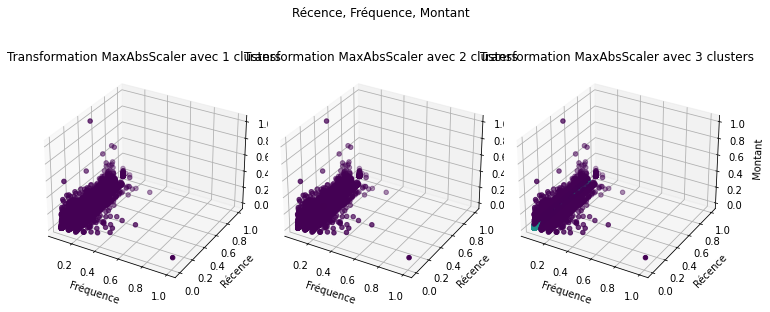

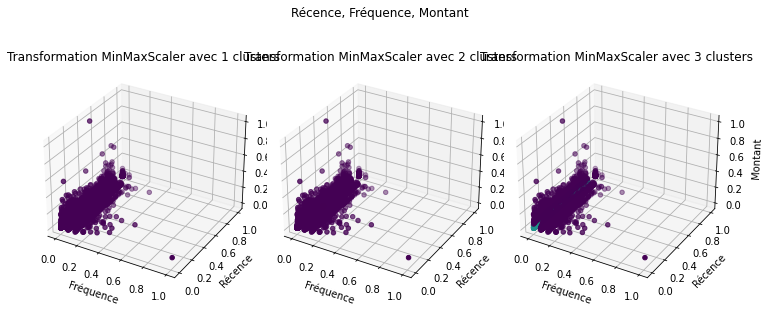

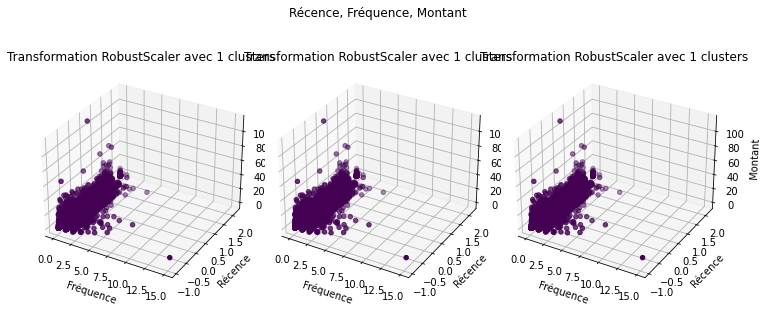

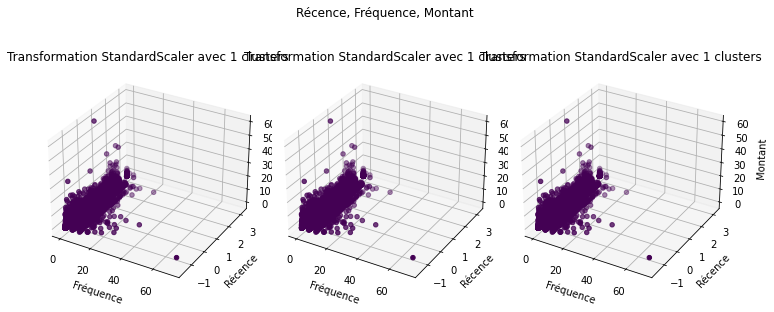

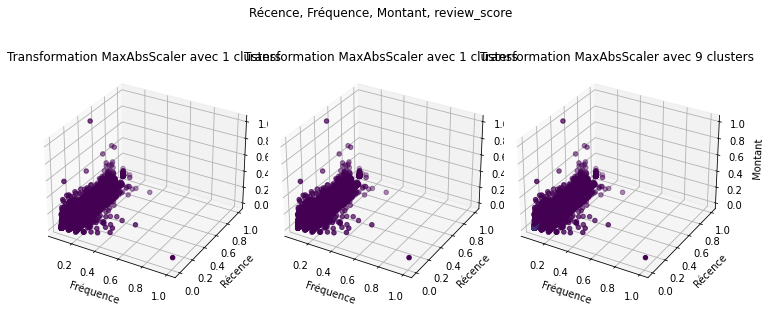

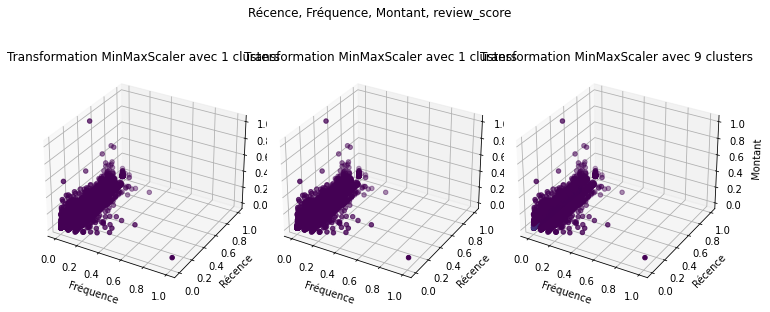

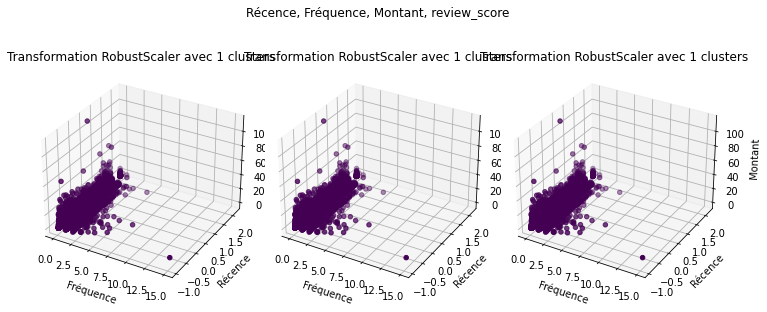

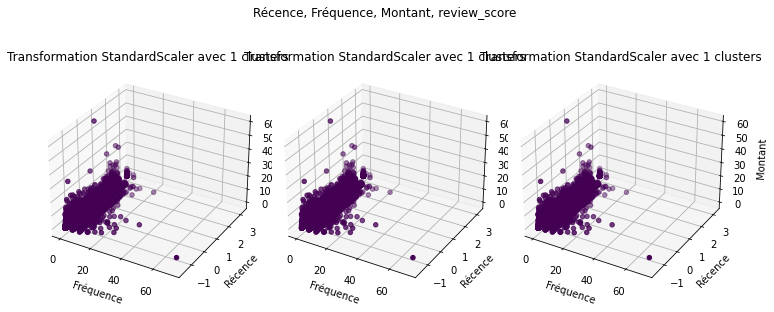

In [21]:
min_samples = 500
dict_params = {'min_samples':min_samples}
dict_test = {'eps':n_epsilon}
df_resultats = algo_clustering(df, dict_params, dict_test, df_resultats, listCombiVar, listNormStand, 'DBSCAN')

In [22]:
df_resultats[df_resultats['Algo'] == 'DBSCAN'].sort_values('Score_silhouette', ascending = False)

,Algo,Paramètres,Transformation,Variables,nb_clusters,N_obs,Score_silhouette,Temps_traitement
29,DBSCAN,"{'eps': 0.02, 'min_samples': 500}",MinMaxScaler,"[Récence, Fréquence, Montant]",3,"[5045, 88021, 1238]",-0.25,18.15
26,DBSCAN,"{'eps': 0.02, 'min_samples': 500}",MaxAbsScaler,"[Récence, Fréquence, Montant]",3,"[5042, 88024, 1238]",-0.25,16.41
28,DBSCAN,"{'eps': 0.002, 'min_samples': 500}",MinMaxScaler,"[Récence, Fréquence, Montant]",2,"[93066, 1238]",-0.29,2.55
25,DBSCAN,"{'eps': 0.002, 'min_samples': 500}",MaxAbsScaler,"[Récence, Fréquence, Montant]",2,"[93066, 1238]",-0.29,2.68
38,DBSCAN,"{'eps': 0.02, 'min_samples': 500}",MaxAbsScaler,"[Récence, Fréquence, Montant, review_score]",9,"[16601, 51754, 16267, 4070, 1814, 599, 1497, 989, 713]",-0.40,11.76
41,DBSCAN,"{'eps': 0.02, 'min_samples': 500}",MinMaxScaler,"[Récence, Fréquence, Montant, review_score]",9,"[16601, 51754, 16267, 4070, 1814, 599, 1497, 989, 713]",-0.40,11.28
24,DBSCAN,"{'eps': 0.0005, 'min_samples': 500}",MaxAbsScaler,"[Récence, Fréquence, Montant]",1,[94304],-1,1.53
46,DBSCAN,"{'eps': 0.002, 'min_samples': 500}",StandardScaler,"[Récence, Fréquence, Montant, review_score]",1,[94304],-1,3.79
45,DBSCAN,"{'eps': 0.0005, 'min_samples': 500}",StandardScaler,"[Récence, Fréquence, Montant, review_score]",1,[94304],-1,3.77
44,DBSCAN,"{'eps': 0.02, 'min_samples': 500}",RobustScaler,"[Récence, Fréquence, Montant, review_score]",1,[94304],-1,3.38


# Finalisation
## Choix du meilleur modèle

In [23]:
df_resultats['Min'] = df_resultats.N_obs.apply(lambda x: min(x))
df_resultats.loc[(df_resultats['Score_silhouette'] <= 0.2)
                 |(df_resultats['Temps_traitement'] >= 1)
                 |(df_resultats['nb_clusters'] >= 10)
                 |(df_resultats['Min'] <= 500)
                 ,'Valide'] = -1
df_resultats = df_resultats.drop(columns = ['Min'])

In [24]:
# Affichage du top 10
df_best = df_resultats[df_resultats['Valide'] != -1].sort_values('Score_silhouette', ascending = False).iloc[:10]
df_best

,Algo,Paramètres,Transformation,Variables,nb_clusters,N_obs,Score_silhouette,Temps_traitement,Valide
7,MiniBatchKMeans,"{'n_clusters': 4, 'init': 'k-means++'}",RobustScaler,"[Récence, Fréquence, Montant]",4,"[46612, 6219, 40642, 831]",0.43,0.24,NaN
6,MiniBatchKMeans,"{'n_clusters': 3, 'init': 'k-means++'}",RobustScaler,"[Récence, Fréquence, Montant]",3,"[40800, 49383, 4121]",0.41,0.23,NaN
11,MiniBatchKMeans,"{'n_clusters': 5, 'init': 'k-means++'}",StandardScaler,"[Récence, Fréquence, Montant]",5,"[21724, 57691, 2857, 2520, 9512]",0.38,0.20,NaN
8,MiniBatchKMeans,"{'n_clusters': 5, 'init': 'k-means++'}",RobustScaler,"[Récence, Fréquence, Montant]",5,"[21471, 3131, 33098, 17954, 18650]",0.33,0.05,NaN
10,MiniBatchKMeans,"{'n_clusters': 4, 'init': 'k-means++'}",StandardScaler,"[Récence, Fréquence, Montant]",4,"[67203, 2869, 21724, 2508]",0.32,0.09,NaN
9,MiniBatchKMeans,"{'n_clusters': 3, 'init': 'k-means++'}",StandardScaler,"[Récence, Fréquence, Montant]",3,"[2880, 67626, 23798]",0.31,0.13,NaN
0,MiniBatchKMeans,"{'n_clusters': 3, 'init': 'k-means++'}",MaxAbsScaler,"[Récence, Fréquence, Montant]",3,"[24388, 36660, 33256]",0.29,0.31,NaN
1,MiniBatchKMeans,"{'n_clusters': 4, 'init': 'k-means++'}",MaxAbsScaler,"[Récence, Fréquence, Montant]",4,"[36660, 17111, 24388, 16145]",0.22,0.04,NaN
20,MiniBatchKMeans,"{'n_clusters': 5, 'init': 'k-means++'}",RobustScaler,"[Récence, Fréquence, Montant, review_score]",5,"[37873, 19596, 1058, 28863, 6914]",0.20,0.11,NaN


## Interprétation des clusters

Les performances des modèles en termes de score ne suffisent pas, il faut aussi avoir des clusters interprétables. C'est pour cela que je vais afficher les 5 meilleurs modèles en termes de scores et choisir le plus interprétable.

In [26]:
for i in [*range(0,df_best.shape[0])]:
    print('=============')
    print()
    # récupération du modèle en cours
    dict_best = df_best.iloc[i].to_dict()
    print("Modèle",dict_best['Algo'],"avec",dict_best['nb_clusters']
          ,"clusters pour un score silouhette de",round(dict_best['Score_silhouette'],2)
          ,"et un temps de traitement de",round(dict_best['Temps_traitement'],2))
    print('Transformation :',dict_best['Transformation'])
    # lancement du modèle
    preprocessor = globals()[dict_best['Transformation']]()
    algo = globals()[dict_best['Algo']](dict_best['nb_clusters'])
    model = make_pipeline(preprocessor, algo)
    model.fit_predict(df.loc[:, dict_best['Variables']])
    # ajout des clusters au df
    df['labels'] = model.steps[-1][1].labels_
    df['labels'] = df['labels'].astype(str)
    # affichage des distributions des clusters
    print('Modalités :')
    print(df['labels'].value_counts())
    # affichage des variables explicatives du modèle
    for var in dict_best['Variables']:
        print(df.groupby('labels').agg({var:['min','max','mean']}))
        print()
        print('-------')
        print()


Modèle MiniBatchKMeans avec 4 clusters pour un score silouhette de 0.43 et un temps de traitement de 0.24
Transformation : RobustScaler
Modalités :
0    48747
3    34333
2    10373
1      851
Name: labels, dtype: int64
       Récence            
           min  max   mean
labels                    
0            4  279 134.43
1            8  695 243.70
2            0  698 242.07
3          259  728 395.42

-------

       Fréquence         
             min max mean
labels                   
0              1   3 1.02
1              1   9 1.11
2              1  16 1.12
3              1   6 1.02

-------

       Montant                 
           min      max    mean
labels                         
0         9.59   297.00  111.75
1      1156.00 13664.00 1769.00
2       273.00  1153.00  482.50
3        10.07   319.00  106.25

-------


Modèle MiniBatchKMeans avec 3 clusters pour un score silouhette de 0.41 et un temps de traitement de 0.23
Transformation : RobustScaler
Modalités :
0    5

Je peux donc voir que ...

# Conclusions

Je viens de segmenter la base de données en 3 types de clients suivant 2 axes : sa valeur et sa satisfaction.

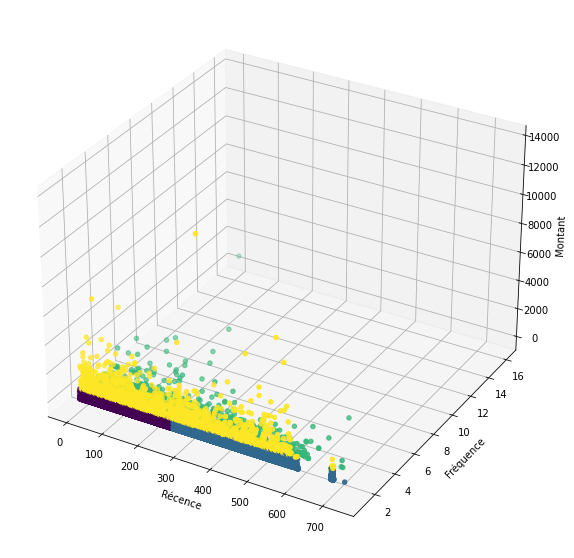

In [27]:
# choix 
kmeans = 'MiniBatchKMeans'
transformation = 'StandardScaler'
n_clusters = 4
var = ['Récence','Fréquence','Montant']
# lancement du modèle
df_temp = df.loc[:, var].copy()
preprocessor = globals()[transformation]()
algo = globals()[kmeans](n_clusters)
model = make_pipeline(preprocessor, algo)
model.fit_predict(df_temp)
# ajout des clusters au df
df_temp['labels'] = model.steps[-1][1].labels_

fig,ax = plt.subplots(figsize = (20,10), subplot_kw = dict(projection = '3d'))
a = df_temp.iloc[:,0]
b = df_temp.iloc[:,1]
c = df_temp.iloc[:,2]
ax.scatter(a, b, c, c = df_temp['labels'])
ax.set_xlabel(a.name)
ax.set_ylabel(b.name)
ax.set_zlabel(c.name)
plt.show();